In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
!wget https://drive.google.com/file/d/1u914hmhDJc8qFsAt3lkSKP72dAJIKmnb/view?usp=share_link

--2022-10-31 04:49:24--  https://drive.google.com/file/d/1u914hmhDJc8qFsAt3lkSKP72dAJIKmnb/view?usp=share_link
Resolving drive.google.com (drive.google.com)... 142.250.97.139, 142.250.97.100, 142.250.97.138, ...
Connecting to drive.google.com (drive.google.com)|142.250.97.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=share_link’

view?usp=share_link     [ <=>                ]  72.64K  --.-KB/s    in 0.001s  

2022-10-31 04:49:24 (75.1 MB/s) - ‘view?usp=share_link’ saved [74379]



## Librerias

In [22]:
import warnings
warnings.filterwarnings("ignore")
# loading packages
# basic + dates
import numpy as np
import math
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
from sklearn import preprocessing
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#modelo
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

## Load data

In [116]:
# importing train data to learn
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv",
parse_dates = True, low_memory = False, index_col = 'date')

In [14]:
# additional store data
store = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stores.csv',
low_memory = False)
oil = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/oil.csv',
low_memory = False)
#transactions = pd.read_csv('/content/transactions.csv',
# low_memory = False)
holiday = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/holidays_events.csv',
low_memory = False)


In [117]:
 train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


## Data management and database union

In [118]:
holiday['date']=holiday['date'].astype('datetime64')
oil['date']=oil['date'].astype('datetime64')
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [119]:
data = pd.merge(train, holiday, how = 'left', on = 'date')
print("In total: ", data.shape)
data = pd.merge(data, oil, how = 'left', on = 'date')
print("In total: ", data.shape)
data = pd.merge(data, store, how = 'left', on = 'store_nbr')
print("In total: ", data.shape)
data.head()

In total:  (3054348, 11)
In total:  (3054348, 12)
In total:  (3054348, 16)


,date,id,store_nbr,family,sales,onpromotion,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,2013-01-01,1,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2013-01-01,2,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,2013-01-01,3,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,2013-01-01,4,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


In [120]:
lb =preprocessing.LabelEncoder()
data['family'] = lb.fit_transform(data['family'])
data['type_x'] = lb.fit_transform(data['type_x'])
data['locale'] = lb.fit_transform(data['locale'])
data['locale_name'] = lb.fit_transform(data['locale_name'])
data['description'] = lb.fit_transform(data['description'])
data['transferred'] = lb.fit_transform(data['transferred'])
data['city'] = lb.fit_transform(data['city'])
data['state'] = lb.fit_transform(data['state'])
data['type_y'] = lb.fit_transform(data['type_y'])

## Create date variables

In [121]:
def create_features(data):
    data = data.copy()
    data['Year'] = data.index.year
    data['Month'] = data.index.month
    data['Day'] = data.index.day
    data['WeekOfYear'] = data.index.weekofyear
    data['dayofweek'] = data.index.dayofweek
    data['dayofyear'] = data.index.dayofyear
    return data

In [122]:
data['date'] = pd.to_datetime(data['date'])
#data = data.set_index('date')

In [123]:
data = create_features(data)

AttributeError: ignored

In [ ]:
data = data.fillna(method="bfill")
data.head()

### Heat map and pearson correlation

id             0.216317
store_nbr     -0.018231
family        -0.063803
sales          1.000000
onpromotion    0.539420
type_x        -0.014835
locale        -0.012821
locale_name   -0.012987
description   -0.011842
transferred   -0.013205
dcoilwtico    -0.180431
city           0.034720
state          0.069197
type_y        -0.022814
cluster        0.035308
dtype: float64


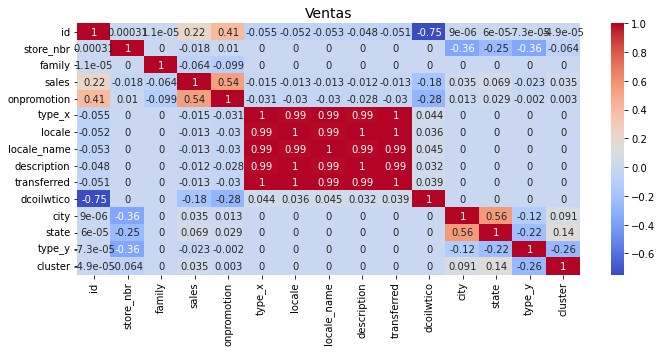

In [124]:
# Correlacion Pearson
corr1 = data.corr(method='spearman')
corr_pairs1 = corr1.unstack()
print(corr_pairs1["sales"])
# Visualizar Heatmap
fig, axes = plt.subplots(figsize=(10, 5))
fig.suptitle('')
sns.heatmap(corr1, annot=True, annot_kws={"size": 10}, cmap= 'coolwarm',ax=axes)
axes.set_title('Ventas', fontsize=14)
plt.tight_layout()
plt.show()


The variables most closely related to sales are year, dcoilwtico and onpromotion

In [125]:
from sklearn import preprocessing   

In [163]:
#x = data[['onpromotion','dcoilwtico','Year','family','city','state','cluster','Month','dayofyear']]
#y = data[['sales']]
# Splitting the data into train and test
#trainX, testX, trainY, testY = train_test_split(x, y, train_size=0.8,random_state=42, shuffle=False)
#trainX.shape, testX.shape

train_dates = data['date']

x = data[['store_nbr','onpromotion', 'transferred', 'dcoilwtico','family','city','state','cluster']].astype(float)
y = data[['sales']]

X = preprocessing.StandardScaler().fit(x).transform(x)
x.shape[1]

            sales
0           0.000
1           0.000
2           0.000
3           0.000
4           0.000
...           ...
3054343   438.133
3054344   154.553
3054345  2419.729
3054346   121.000
3054347    16.000

[3054348 rows x 1 columns]


In [127]:
trainX = []
trainY = []

n_future = 1  #Number of days we want to predict into the future
n_past = 21   #Number of past days we want to use to predict the future

for i in range(n_past, len(X) - n_future + 1):
    trainX.append(X[i - n_past:i, 0: x.shape[1]])
    trainY.append(X[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

In [128]:
print(trainX.shape)
print(trainY.shape)

(3054327, 21, 8)
(3054327, 1)


In [129]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential([
    LSTM(32, activation = 'relu', return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])),
    LSTM(16, activation = 'relu', return_sequences = False),
    Dropout(0.2),
    Dense(trainY.shape[1])
])

In [ ]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 21, 32)            5248      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 8,401
Trainable params: 8,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs = 1, batch_size = 32, validation_split = 0.1, verbose = 1)

85903/85903 [==============================] - 5864s 68ms/step - loss: 0.0446 - val_loss: 0.0056


In [ ]:
model.save('LSTM_model.h5')

Work with test data

In [130]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [131]:
valid_data = pd.merge(test_data, holiday, how = 'left', on = 'date')
print("In total: ", valid_data.shape)
valid_data = pd.merge(valid_data, oil, how = 'left', on = 'date')
print("In total: ", valid_data.shape)
valid_data = pd.merge(valid_data, store, how = 'left', on = 'store_nbr')
print("In total: ", valid_data.shape)
valid_data.head()

In total:  (28512, 10)
In total:  (28512, 11)
In total:  (28512, 15)


,id,date,store_nbr,family,onpromotion,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,0,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,2,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,20,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,0,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,13


In [182]:
lb =preprocessing.LabelEncoder()
valid_data['family'] = lb.fit_transform(valid_data['family'])
valid_data['type_x'] = lb.fit_transform(valid_data['type_x'])
valid_data['locale'] = lb.fit_transform(valid_data['locale'])
valid_data['locale_name'] = lb.fit_transform(valid_data['locale_name'])
valid_data['description'] = lb.fit_transform(valid_data['description'])
valid_data['transferred'] = lb.fit_transform(valid_data['transferred'])
valid_data['city'] = lb.fit_transform(valid_data['city'])
valid_data['state'] = lb.fit_transform(valid_data['state'])
valid_data['type_y'] = lb.fit_transform(valid_data['type_y'])

test_data =  valid_data[['store_nbr','onpromotion', 'transferred', 'dcoilwtico','family','city','state','cluster']].astype(float)

testx = preprocessing.StandardScaler().fit(test_data).transform(test_data)
sc = preprocessing.StandardScaler()
true_y = sc.fit_transform(y[0:28491])

print(true_y)

[[-0.28551389]
 [-0.28551389]
 [-0.28551389]
 ...
 [ 0.22958286]
 [-0.15812103]
 [-0.25885027]]


In [149]:
testX = []
testY = []

n_future = 1  #Number of days we want to predict into the future
n_past = 21   #Number of past days we want to use to predict the future

for i in range(n_past, len(testx) - n_future + 1):
    testX.append(testx[i - n_past:i, 0: testx.shape[1]])

tesX, tesY = np.array(testX), np.array(trainY[0:28491])

In [170]:
print(tesY)

[[-1.70026736]
 [-1.70026736]
 [-1.70026736]
 ...
 [-1.1869791 ]
 [-1.1869791 ]
 [-1.1869791 ]]


In [51]:
test_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/LSTM_model.h5')

In [52]:
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 21, 32)            5248      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 8,401
Trainable params: 8,401
Non-trainable params: 0
_________________________________________________________________


In [183]:
predicted_sales = sc.inverse_transform(test_model.predict(tesX))

891/891 [==============================] - 5s 6ms/step


In [148]:
predicted_sales.shape

(28491, 1)

In [184]:
y_pred = preprocessing.StandardScaler().fit(tesY).inverse_transform(predicted_sales)
y_pred = predicted_sales * -1

In [185]:
print(y_pred)

[[880.8447 ]
 [889.4662 ]
 [885.5431 ]
 ...
 [580.62634]
 [580.9203 ]
 [582.543  ]]


In [192]:
submissionFile = pd.DataFrame(y_pred).reset_index()
submissionFile.columns = ["id","sales"]
submissionFile["sales"] = abs ( submissionFile["sales"] )
submissionFile.head()

,id,sales
0,0,880.844727
1,1,889.466187
2,2,885.543091
3,3,891.141113
4,4,889.236328


In [190]:
submissionFile.to_csv( "./submissionFile.csv" )

In [ ]:
# Calculate mean absolute percentage error
def mape_func(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    '''
    print('Evaluation metric results: ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

### Model Training

In [ ]:
#xgB = XGBRegressor( n_estimators=30, objective='reg:squarederror')
#xgB

#xgB.fit(trainX, trainY,
 #   eval_set=[(trainX, trainY),(testX, testY)],
  #  early_stopping_rounds=50,
   # verbose= False)

In [ ]:
plot_importance(xgB)
plt.show()

### Evaluación modelo

In [ ]:
predicted_results = xgB.predict(testX)
predicted_results

In [ ]:
timeseries_evaluation_metrics_func(testY, predicted_results)


### Evaluación mediante RMSLE

The RMSLE is calculated as:
[\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}]
where:

𝑛 is the total number of instances,
𝑦̂ 𝑖 is the predicted value of the target for instance (i),
𝑦𝑖 is the actual value of the target for instance (i), and,
log is the natural logarithm.

In [ ]:
def RMSLE(y_true: np.array, y_pred: np.array) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
        
    :param y_true: The ground truth labels given in the dataset
    :param y_pred: Our predictions
    :return: The RMSLE score
    """
    return mean_squared_log_error(y_true, y_pred, squared=False)

La métrica RMSLE no admite resultados negativos, y la predicción de XGBoost genera predicciones negativas 

In [ ]:
# Predicciones negativas
print("Las predicciones negativas son {} y representan un {} %".format( str( len(predicted_results[predicted_results < 0]) ), str( ( len(predicted_results[predicted_results < 0]) / len(predicted_results) ) * 100 ) ))

In [ ]:
RMSLE(testY, abs(predicted_results))

### Submission File

For each id in the test set, you must predict a value for the sales variable. The file should contain a header and have the following format:

id,sales
3000888,0.0
3000889,0.0
3000890,0.0
3000891,0.0
3000892,0.0
etc.

* Se coloca una conversión con valor absoluto por dos razones, la primera es que se utilizó así para poder determianr el RMSLE y la segunda es que se parte del supuesto de que no existen ventas negativas.

In [ ]:
submissionFile = pd.DataFrame( predicted_results ).reset_index()
submissionFile.columns = ["id","sales"]
submissionFile["sales"] = abs ( submissionFile["sales"] )
submissionFile.head()

In [ ]:
submissionFile.to_csv( "./submissionFile.csv" )